In [10]:
from pennylane import numpy as np
import random
import matplotlib.pyplot as plt
import pennylane as qml
import time
from tqdm import tqdm

from cost_function import func_and_deriv
from loss_function import loss_function, u

In [11]:
epochs = 250
num_qubits = 6
d = 5
x = np.linspace(0, 0.9, 20)

n_experiments = 3
init_thetas = []
seeds = []
random_states = []
for i in range(n_experiments):
    RANDOM_STATE = random.randint(0, 2**32 - 1)
    random_states.append(RANDOM_STATE)
    seed = np.random.seed(RANDOM_STATE)
    seeds.append(seed)
    theta_init = np.array(2*np.pi*np.random.random(num_qubits*d*3), requires_grad=True)
    init_thetas.append(theta_init)

nablas = []
for i in range(n_experiments):
    nabla = random.randint(2, 100)
    nablas.append(nabla)

In [12]:
print("States: ", random_states)
print("Seeds: ", seeds)
print()
print("Init thetas (mean): ", np.mean(init_thetas, axis=1))
print("Nablas: ", nablas)

States:  [3859252763, 1989142217, 400511570]
Seeds:  [None, None, None]

Init thetas (mean):  [3.49007569 3.37562969 3.1538407 ]
Nablas:  [87, 96, 6]


In [13]:
def training(init_thetas, nablas):

    assert len(init_thetas) == len(nablas)

    all_opt_thetas = []
    all_losses = []
    for i in range(len(init_thetas)):
        for j in range(len(nablas)):

            theta = init_thetas[i]
            nabla = nablas[j]
            print("THETA: ", i)
            print("NABLA: ", j)
            losses = []
            optimizer = qml.AdamOptimizer() 
            for k in tqdm(range(epochs)):
                #print("Epoch: ", i)
                loss = loss_function(x, num_qubits, d, theta, k, epochs, nabla)
                #print("Loss: ", loss)
                losses.append(loss)

                #print("Starting optimizing...")
                #start = time.time()
                theta_opt = optimizer.step(lambda theta: loss_function(x, num_qubits, d, theta, k, epochs, nabla), theta)
                #end = time.time()
                #print("Optimization done in ", end-start, "s")
                
                theta = theta_opt

            all_opt_thetas.append(theta)
            all_losses.append(losses)

    return all_opt_thetas, all_losses

In [14]:
all_opt_thetas, all_losses = training(init_thetas, nablas)

THETA:  0
NABLA:  0


100%|██████████| 250/250 [2:51:58<00:00, 41.27s/it]  


THETA:  0
NABLA:  1


100%|██████████| 250/250 [2:55:10<00:00, 42.04s/it]  


THETA:  0
NABLA:  2


100%|██████████| 250/250 [2:52:54<00:00, 41.50s/it]  


THETA:  1
NABLA:  0


100%|██████████| 250/250 [2:53:47<00:00, 41.71s/it]  


THETA:  1
NABLA:  1


100%|██████████| 250/250 [2:53:47<00:00, 41.71s/it]  


THETA:  1
NABLA:  2


100%|██████████| 250/250 [2:54:02<00:00, 41.77s/it]  


THETA:  2
NABLA:  0


100%|██████████| 250/250 [2:54:14<00:00, 41.82s/it]  


THETA:  2
NABLA:  1


100%|██████████| 250/250 [2:49:39<00:00, 40.72s/it]  


THETA:  2
NABLA:  2


100%|██████████| 250/250 [3:14:33<00:00, 46.69s/it]   


In [16]:
print(all_opt_thetas)
print()
print()
print(all_losses)

[tensor([3.77871622, 3.75172018, 3.81758375, 5.5851439 , 5.96481095,
        5.50206164, 2.80388141, 6.25309059, 0.30036528, 0.57301973,
        2.46203214, 1.31315543, 2.50838115, 2.30871057, 1.28832508,
        1.66842043, 5.80778638, 2.08189302, 3.31430669, 2.00183067,
        3.78613957, 2.21007804, 3.84487137, 2.47314828, 5.37926463,
        6.23656418, 1.26188037, 2.90499978, 2.20072933, 2.56240601,
        5.57838561, 4.72907286, 5.37131173, 5.3401297 , 3.34120997,
        0.18211863, 4.53341481, 4.24528473, 2.92833513, 1.33216107,
        2.15877385, 5.30329524, 1.4012891 , 1.2740754 , 4.36038451,
        4.46359517, 1.06268211, 0.52166811, 4.61273459, 4.50385667,
        3.12037793, 3.43705979, 5.93566989, 3.13800057, 0.85842513,
        4.0791212 , 2.41499007, 3.83283455, 3.6671694 , 2.85734071,
        1.68849803, 6.11973537, 5.62685434, 3.54459432, 6.31476814,
        5.48388455, 4.25902579, 6.1046863 , 0.12920944, 4.03624464,
        2.19013084, 3.42566481, 5.50030293, 4.9

In [17]:
print(len(all_opt_thetas))

9


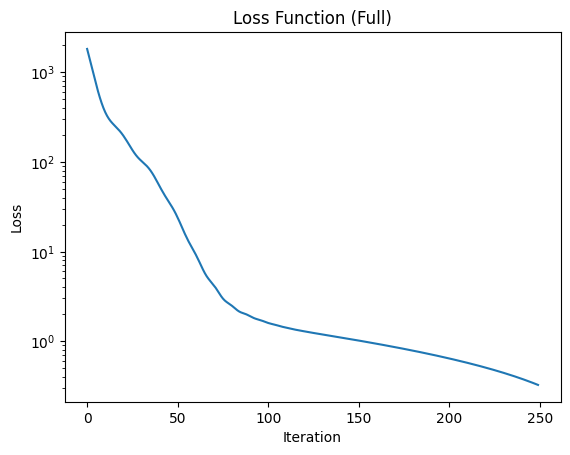

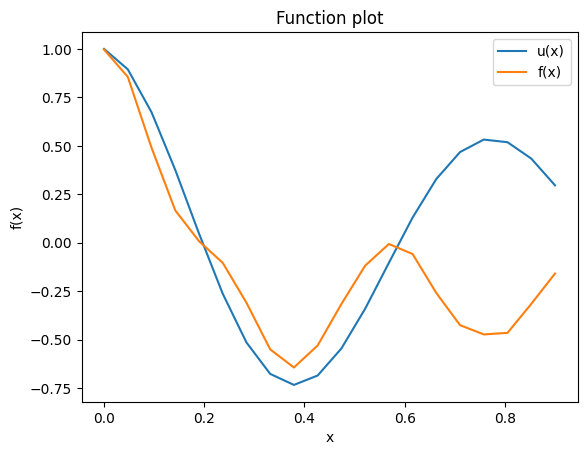

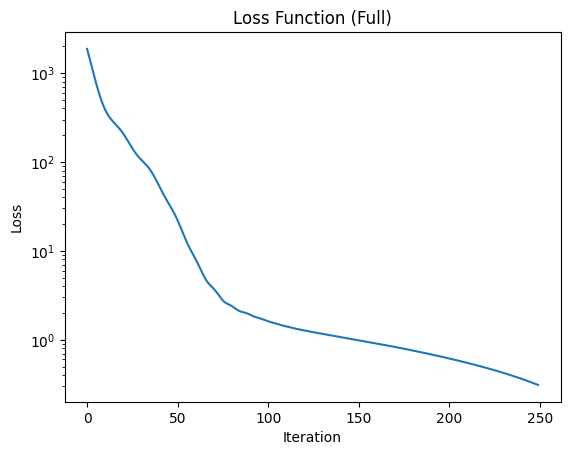

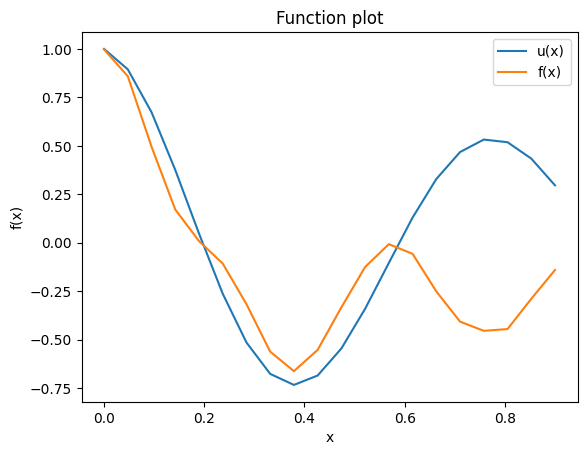

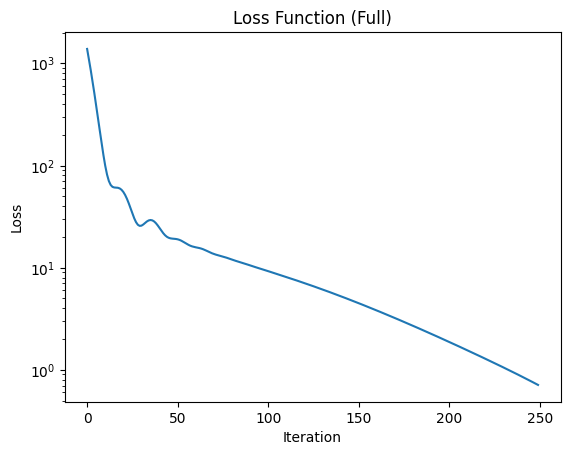

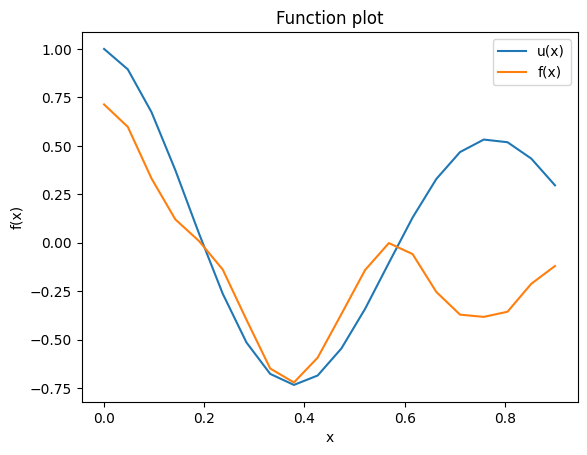

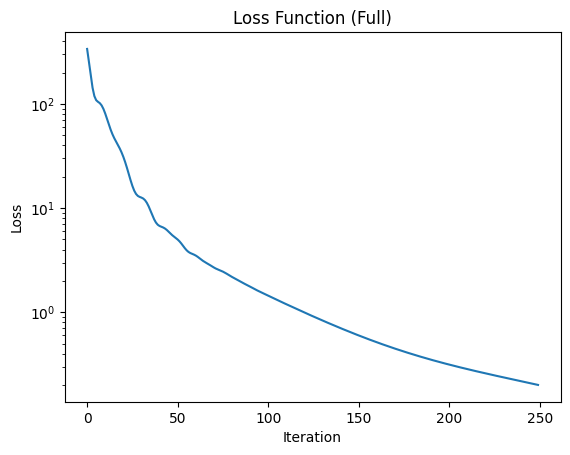

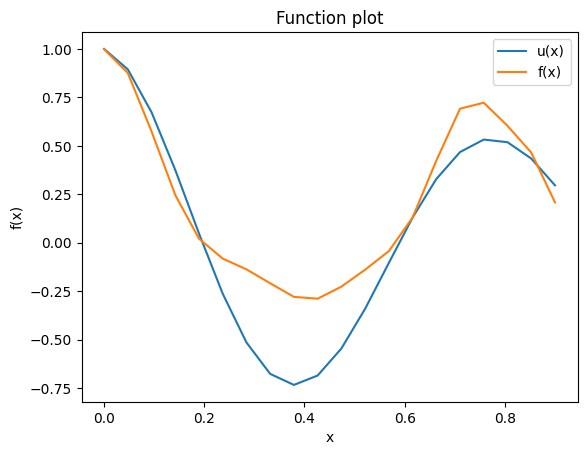

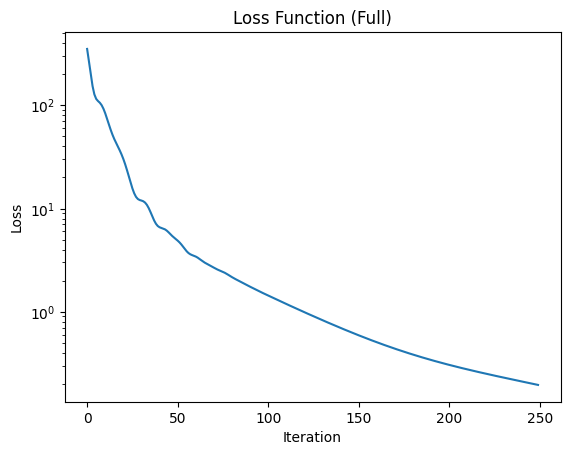

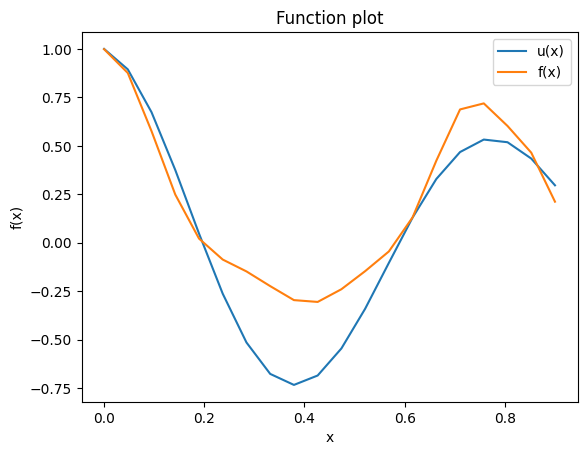

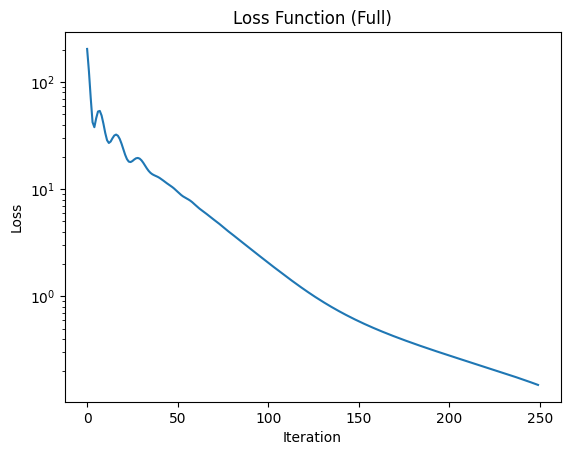

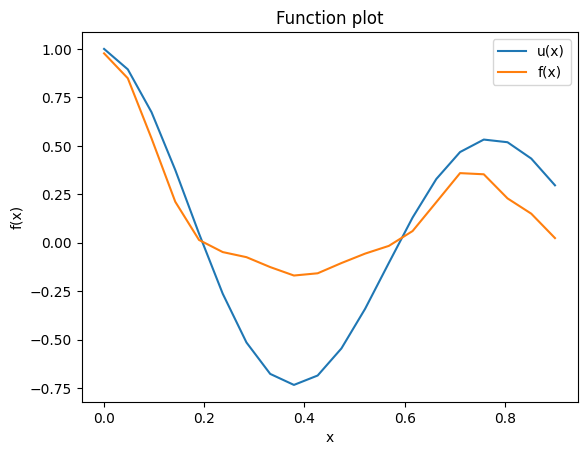

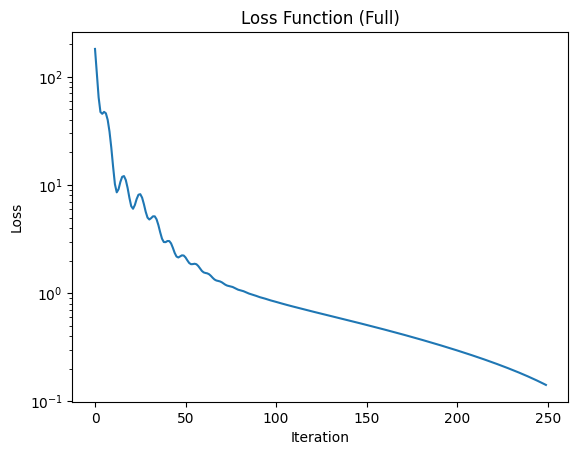

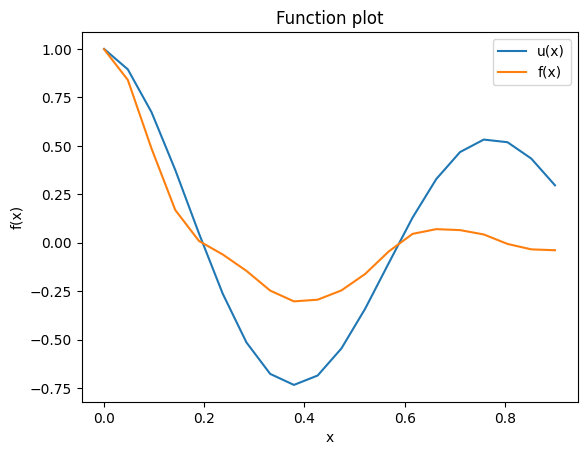

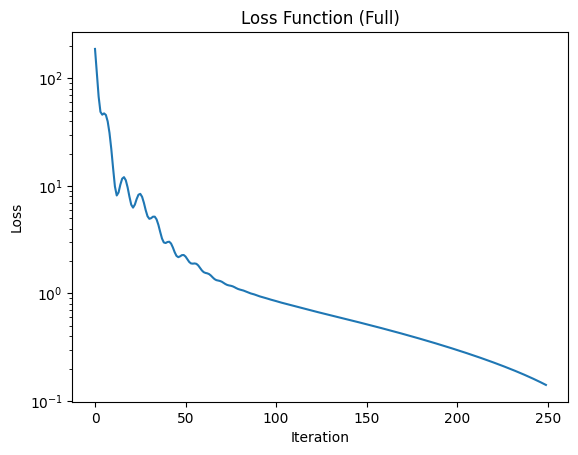

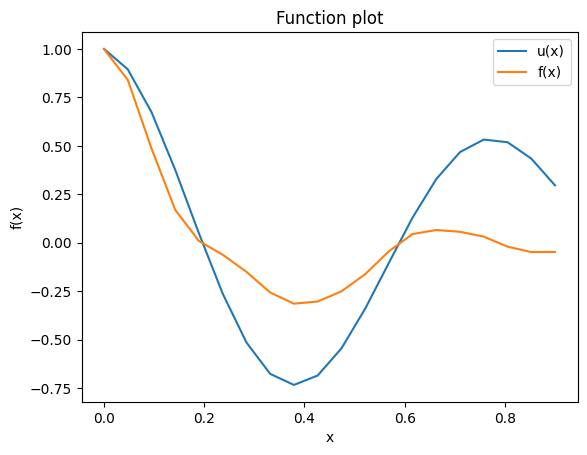

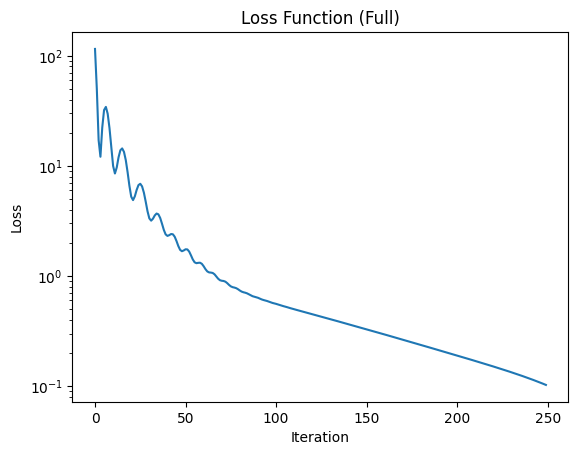

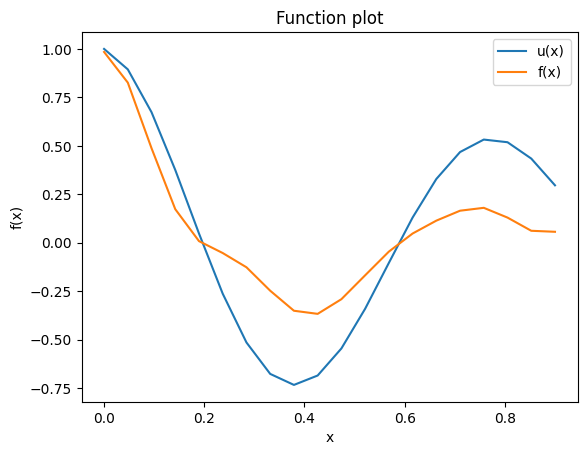

In [18]:
all_functions = []
assert len(all_opt_thetas) == len(all_losses)
for i in range(len(all_opt_thetas)):
    #for j in range(len(all_losses)):

    plt.plot(all_losses[i])
    plt.xlabel("Iteration")     
    plt.ylabel("Loss")
    plt.yscale('log')
    plt.title("Loss Function (Full)")
    plt.savefig(f"losses_pinned_boundary_{i}.png")
    plt.show()

    functions, derivatives = func_and_deriv(x, num_qubits, d, all_opt_thetas[i]) 
    all_functions.append(functions)
    u_plot = u(x)

    plt.plot(x, u_plot, label="u(x)")
    plt.plot(x, functions, label="f(x)")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.legend()
    plt.title("Function plot")
    plt.savefig(f"f_x_pinned_boundary_{i}.png")
    plt.show()

In [27]:
print("Training points: ", x)
print("Initial thetas (mean): ", np.mean(init_thetas, axis=1))
print()
print("Optimal thetas (mean): ", np.mean(all_opt_thetas, axis=1))
#print("True function u(x)", u_plot)
#print("Estimation f(x): ", functions)

#my_loss = diff_loss(functions, derivatives, x)
MSEs = []
for i in range(len(all_functions)):
    mse = np.sum((u_plot-all_functions[i])**2)/len(x)
    MSEs.append(mse.numpy())
last_losses = []
for i in range(len(all_losses)):
    last_losses.append(all_losses[i][-1].numpy())
print("L_f: ", last_losses)
print("L_q: ", MSEs)

Training points:  [0.         0.04736842 0.09473684 0.14210526 0.18947368 0.23684211
 0.28421053 0.33157895 0.37894737 0.42631579 0.47368421 0.52105263
 0.56842105 0.61578947 0.66315789 0.71052632 0.75789474 0.80526316
 0.85263158 0.9       ]
Initial thetas (mean):  [3.49007569 3.37562969 3.1538407 ]

Optimal thetas (mean):  [3.46253039 3.464051   3.46757784 3.36743428 3.36722688 3.37120457
 3.14907527 3.14895798 3.14493562]
L_f:  [0.32480959804859655, 0.31060286092571304, 0.7107250290565481, 0.20034260640098828, 0.194663476479677, 0.14912252166236947, 0.14217195906599245, 0.14126292521045564, 0.10257958125077439]
L_q:  [0.211807462628266, 0.20165405001180886, 0.18737997226173658, 0.052119020152740426, 0.04875311500721039, 0.08874391257864046, 0.09964075680770407, 0.10070557603071517, 0.07115109213103869]
